In [ ]:
라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as pylab
from matplotlib import cm

from skimage import img_as_float, data
from skimage.data import astronaut
from skimage.io import imread
from skimage.color import rgb2gray, label2rgb, gray2rgb, rgba2rgb

from skimage.filters import sobel, threshold_otsu
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.transform import (hough_line, hough_line_peaks, \
                               hough_circle, hough_circle_peaks)
from skimage.segmentation import (felzenszwalb, slic, quickshift, \
                                  watershed, mark_boundaries, find_boundaries)

In [2]:
#영상 보기 함수
def plot_image(image, title, cmap='gray'):
    pylab.imshow(image, cmap=cm), pylab.title(title, size=20), pylab.axis('off')
    
def plot_ax_image(ax, image, title, cmap='gray', size = 20):
    ax.imshow(image, cmap=cmap)
    ax.set_title(title), ax.axis('off')

In [ ]:
Felzenszwalb의 효율적인 그래프 기반 영상 분할

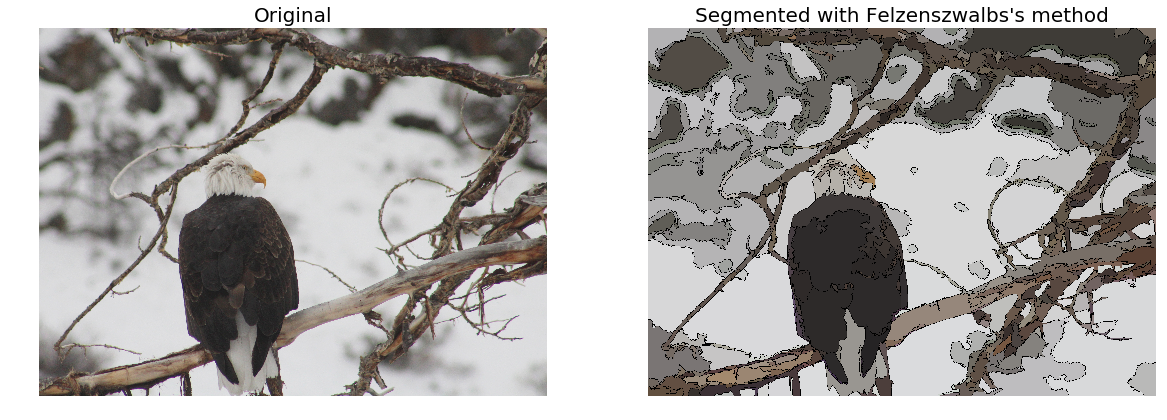

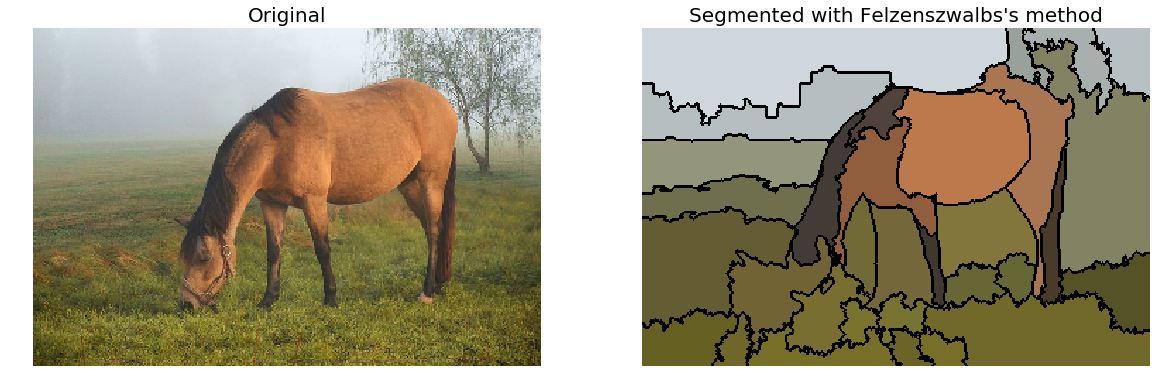

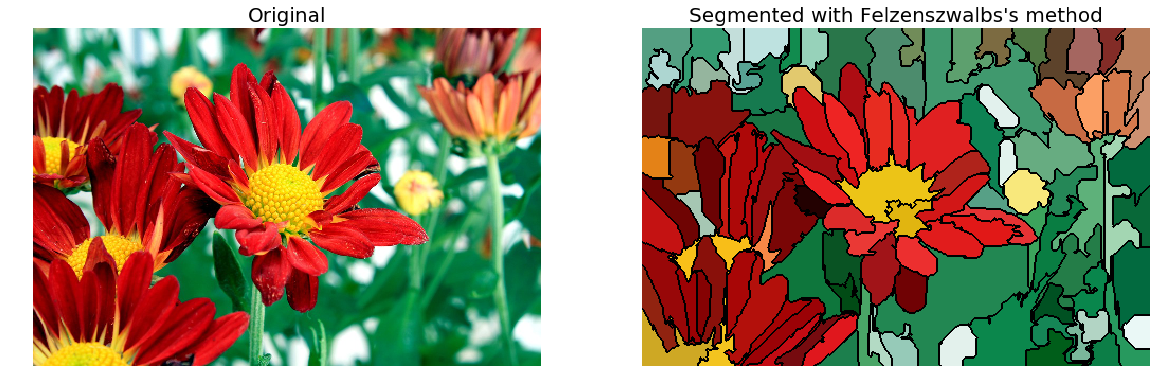

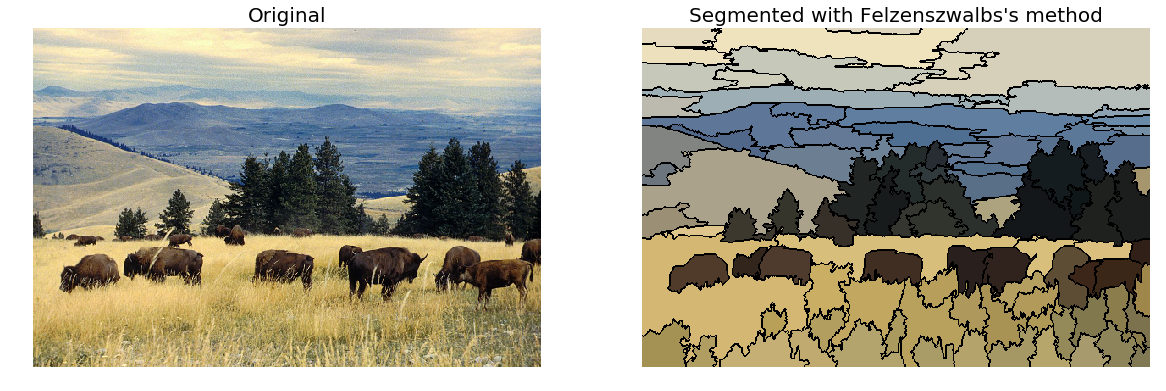

In [6]:
from matplotlib.colors import LinearSegmentedColormap

for imfile in ['eagle.jpg', 'horses.jpg', 'flowers.jpg', 'bisons.jpg']:
    img = img_as_float(imread('../images/'+ imfile)[::2, ::2, :3])
    segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=400)
    borders = find_boundaries(segments_fz)
    unique_colors = np.unique(segments_fz.ravel())
    segments_fz[borders] = -1
    
    colors = [np.zeros(3)]    
    for color in unique_colors:
        colors.append(np.mean(img[segments_fz == color], axis=0))
    cm = LinearSegmentedColormap.from_list('pallete', colors, N=len(colors))
    
    pylab.figure(figsize=(20,10))
    pylab.subplot(121), plot_image(img, 'Original')
    pylab.subplot(122)
    plot_image(segments_fz,'Segmented with Felzenszwalbs\'s method', cmap=cm)
    pylab.show()

In [ ]:
스케일 매개 변수 변경

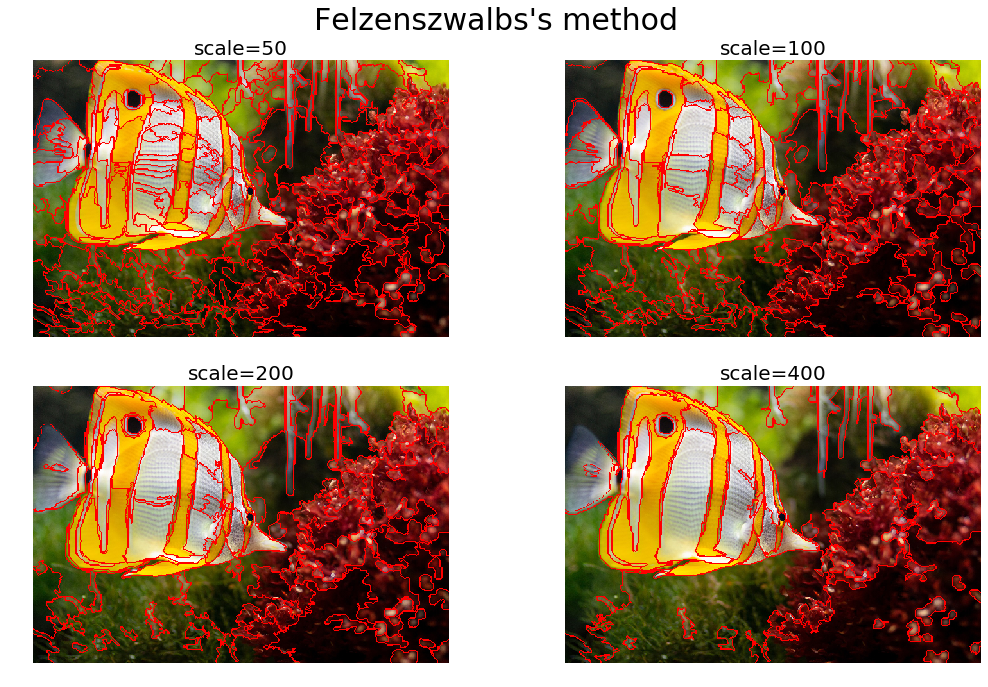

In [7]:
img = imread('../images/fish.jpg')[::2, ::2, :3]
pylab.figure(figsize=(15,10))
for i, scale in enumerate([50, 100, 200, 400]):
    segments_fz = felzenszwalb(img, scale=scale, sigma=0.5, min_size=200)
    seg = mark_boundaries(img, segments_fz, color=(1,0,0))
    pylab.subplot(2,2,i+1), plot_image(seg, 'scale=' + str(scale))\
    
pylab.suptitle('Felzenszwalbs\'s method', size=30)
pylab.tight_layout(rect=[0, 0.03, 1, 0.95])
pylab.show()

In [ ]:
SLIC

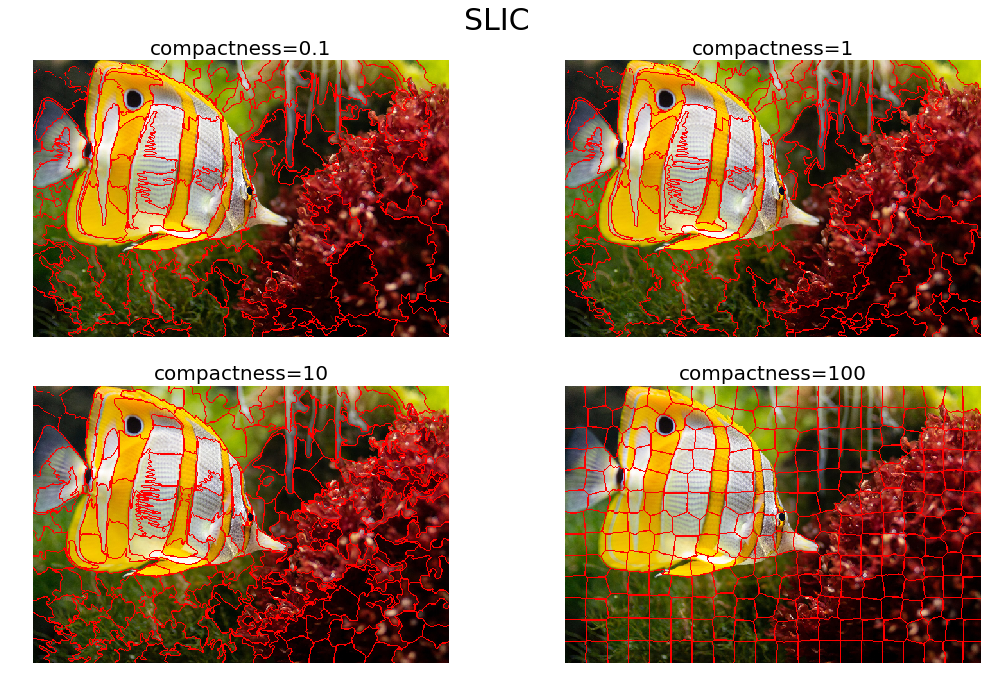

In [9]:
pylab.figure(figsize=(15,10))
for i, compactness in enumerate([0.1, 1, 10, 100]):
    segments_slic = slic(img, n_segments=250, compactness=compactness, sigma=1)
    seg= mark_boundaries(img, segments_slic, color=(1,0,0))
    pylab.subplot(2,2,i+1) , plot_image(seg, 'compactness=' + str(compactness))
    
pylab.suptitle('SLIC', size=30), pylab.tight_layout(rect=[0, 0.03, 1, 0.95])
pylab.show()

In [ ]:
RAG 병합

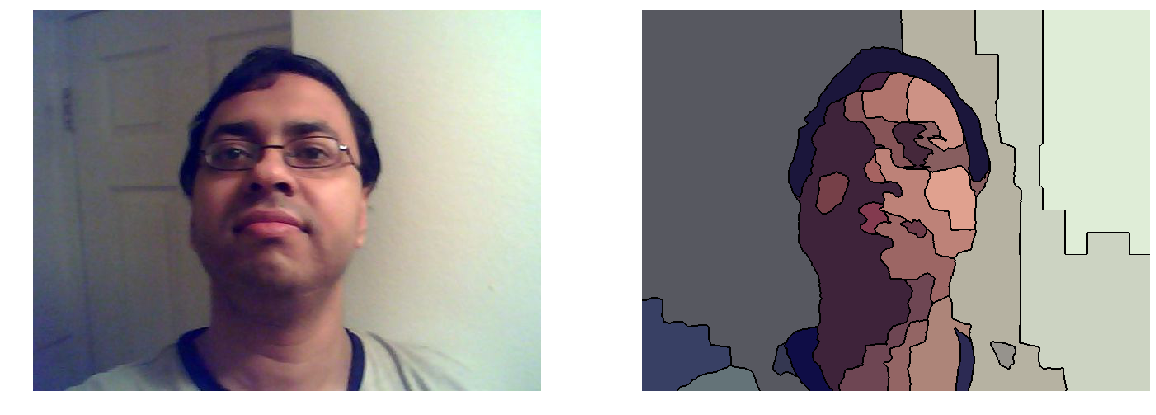

In [11]:
from skimage.future import graph

def _weight_mean_color(graph, src, dst, n):
    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

def merge_mean_color(graph, src, dst):
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] / graph.node[dst]['pixel count'])
    
img = imread('../images/me12.jpg')
labels = slic(img, compactness=30, n_segments=400)
g = graph.rag_mean_color(img, labels)
labels2 = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False, \
                                   in_place_merge=True, merge_func=merge_mean_color, \
                                   weight_func=_weight_mean_color)
out = label2rgb(labels2, img, kind='avg')
out = mark_boundaries(out, labels2, (0, 0, 0))

pylab.figure(figsize=(20,10))
pylab.subplot(121), pylab.imshow(img), pylab.axis('off')
pylab.subplot(122), pylab.imshow(out), pylab.axis('off')
pylab.show()

In [ ]:
QuickShift

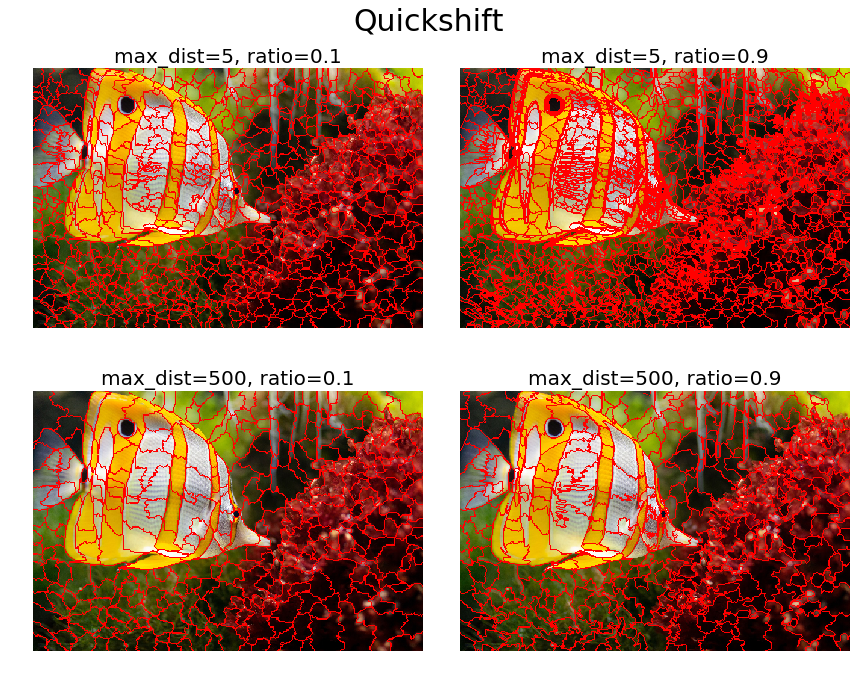

In [13]:
img = imread('../images/fish.jpg')[::2, ::2, :3]
pylab.figure(figsize=(12,10))
i = 1
for max_dist in [5, 500]:
    for ratio in [0.1, 0.9]:
        segments_quick = quickshift(img, kernel_size=3, \
                                    max_dist=max_dist, ratio=ratio)
        boundary = mark_boundaries(img, segments_quick, color=(1,0,0))
        title = 'max_dist=' + str(max_dist) + ', ratio=' + str(ratio)
        pylab.subplot(2,2,i), plot_image(boundary, title)
        i += 1
        
pylab.suptitle('Quickshift', size=30)
pylab.tight_layout(rect=[0, 0.03, 1,0.95])
pylab.show()

In [ ]:
Compact Watershed

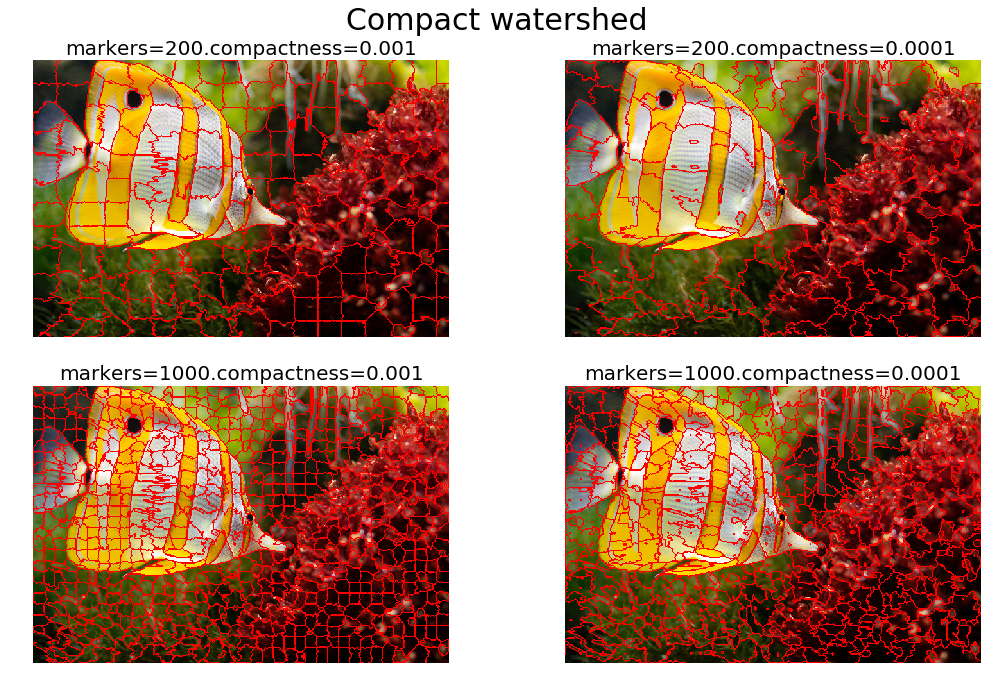

In [14]:
gradient = sobel(rgb2gray(img))
pylab.figure(figsize=(15,10))
i = 1
for markers in [200, 1000]:
    for compactness in [0.001, 0.0001]:
        segments_watershed = watershed(gradient, markers=markers, \
                                       compactness=compactness)
        boundary = mark_boundaries(img, segments_watershed, color=(1,0,0))
        title = 'markers='+str(markers) + '.compactness=' + str(compactness)
        pylab.subplot(2,2,i), plot_image(boundary, title)
        i += 1
        
pylab.suptitle('Compact watershed', size=30)
pylab.tight_layout (rect=[0, 0.03, 1, 0.95])
pylab.show()

In [ ]:
SimpleITK를 사용한 영역 확장

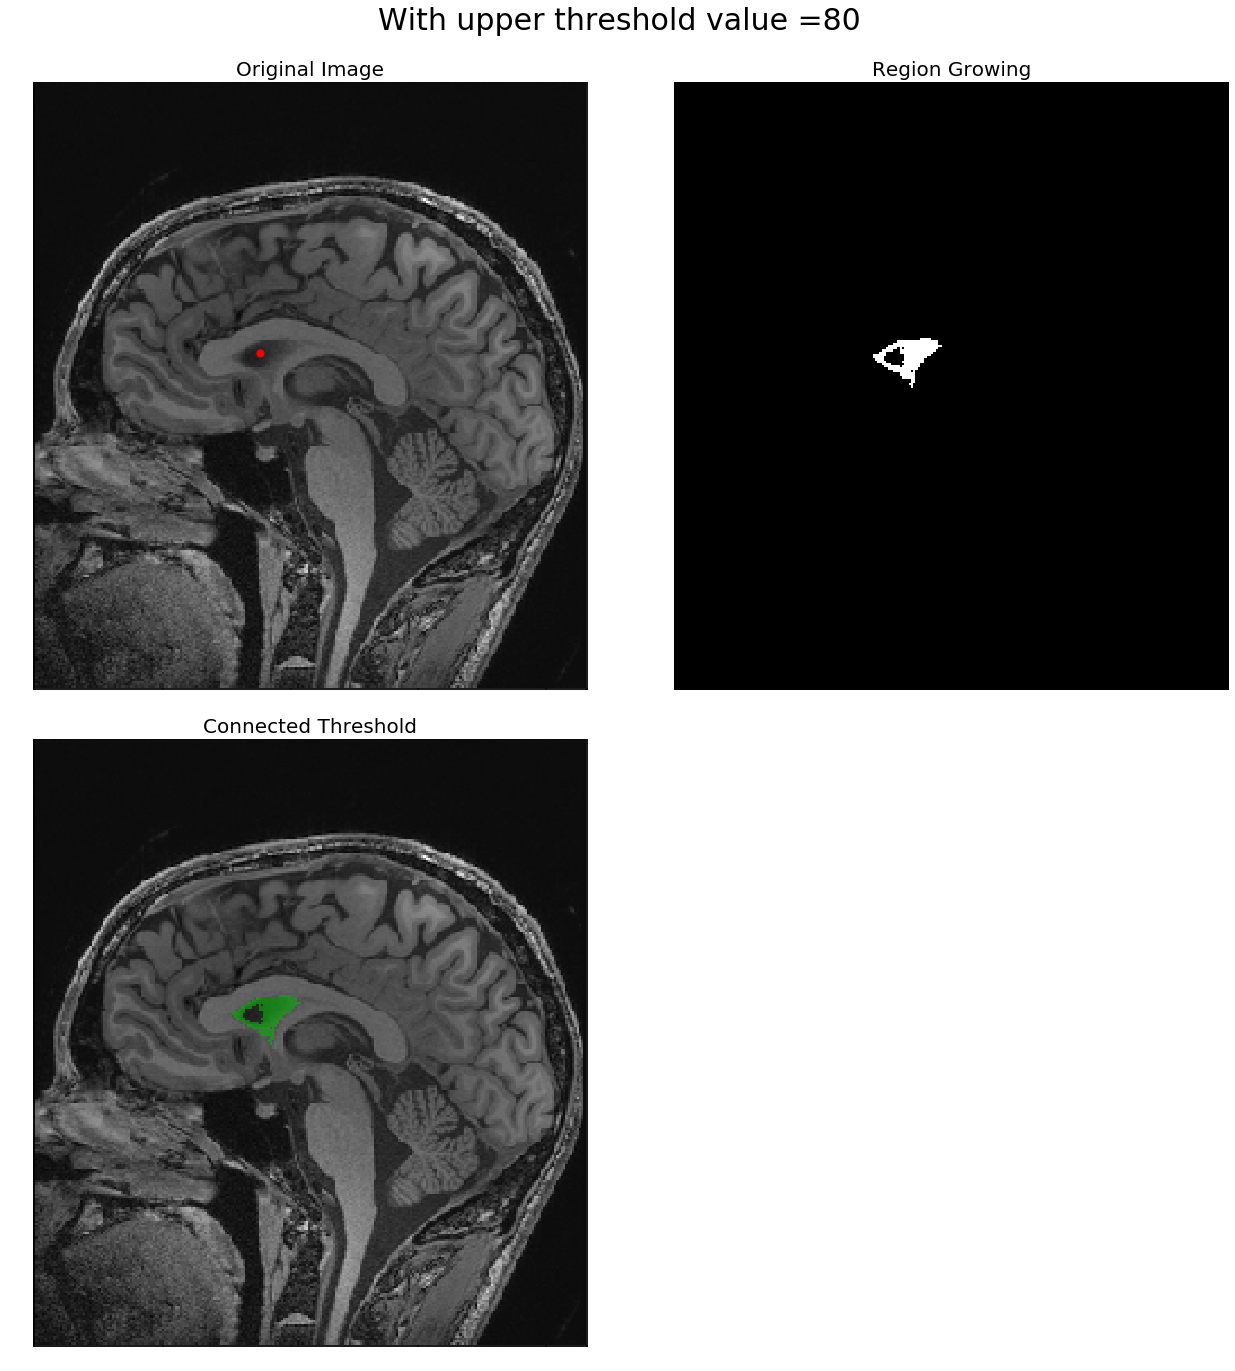

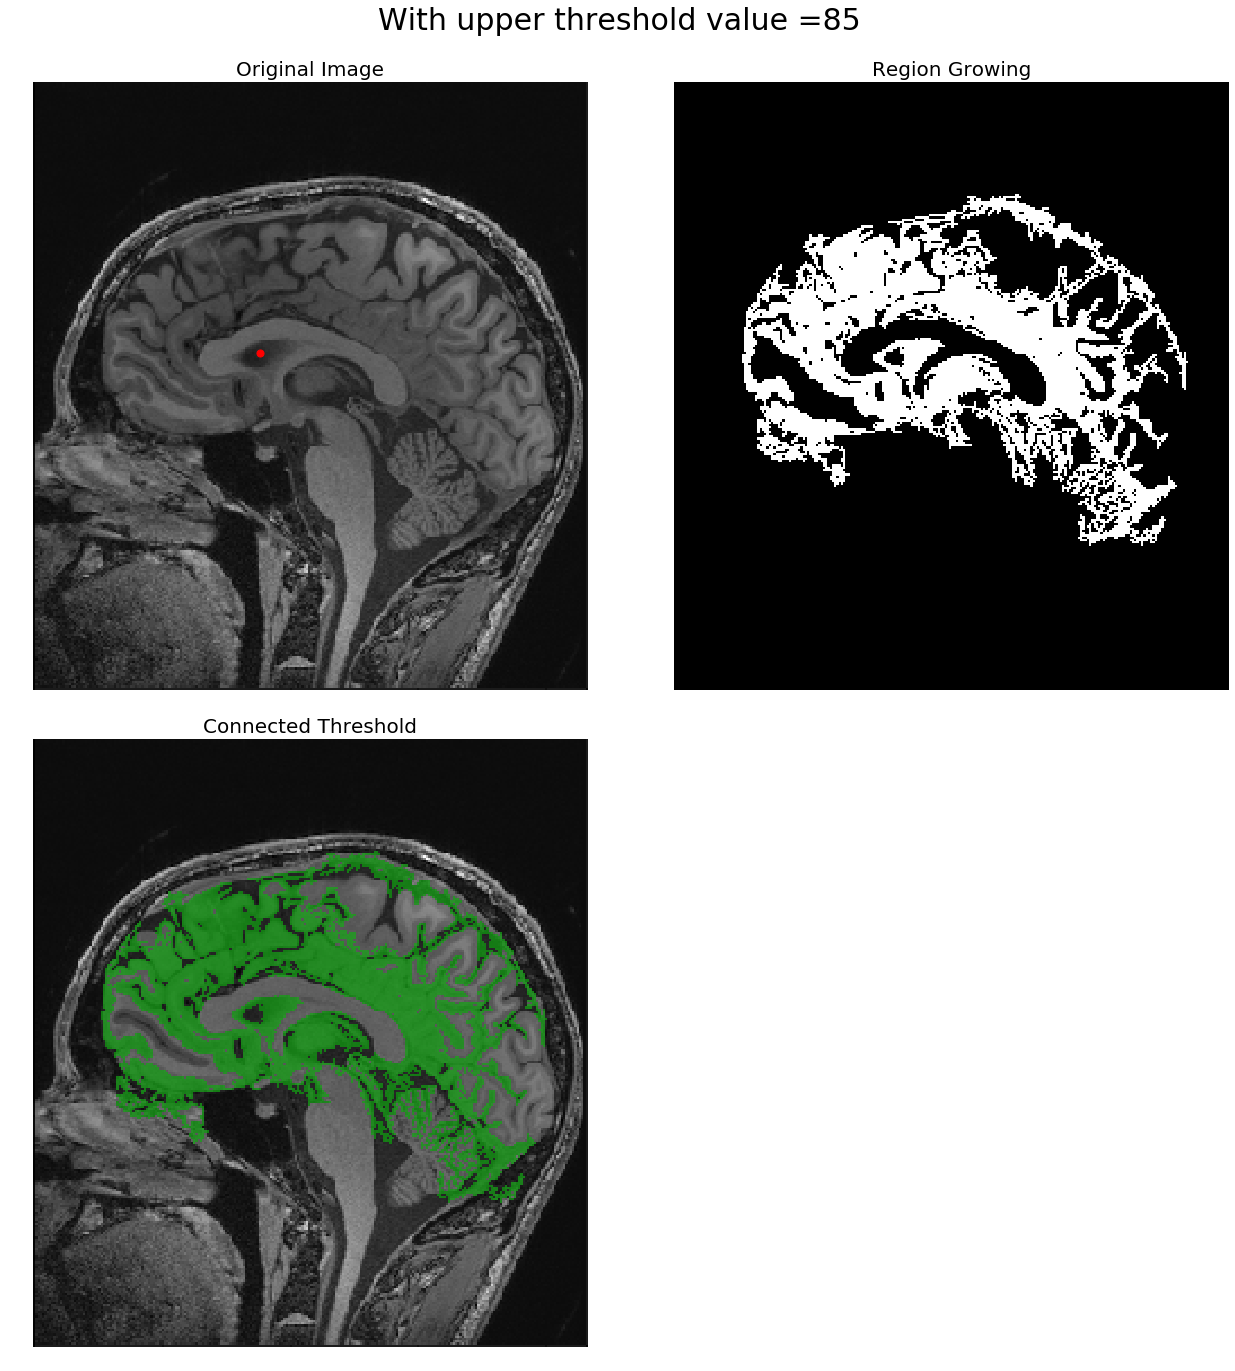

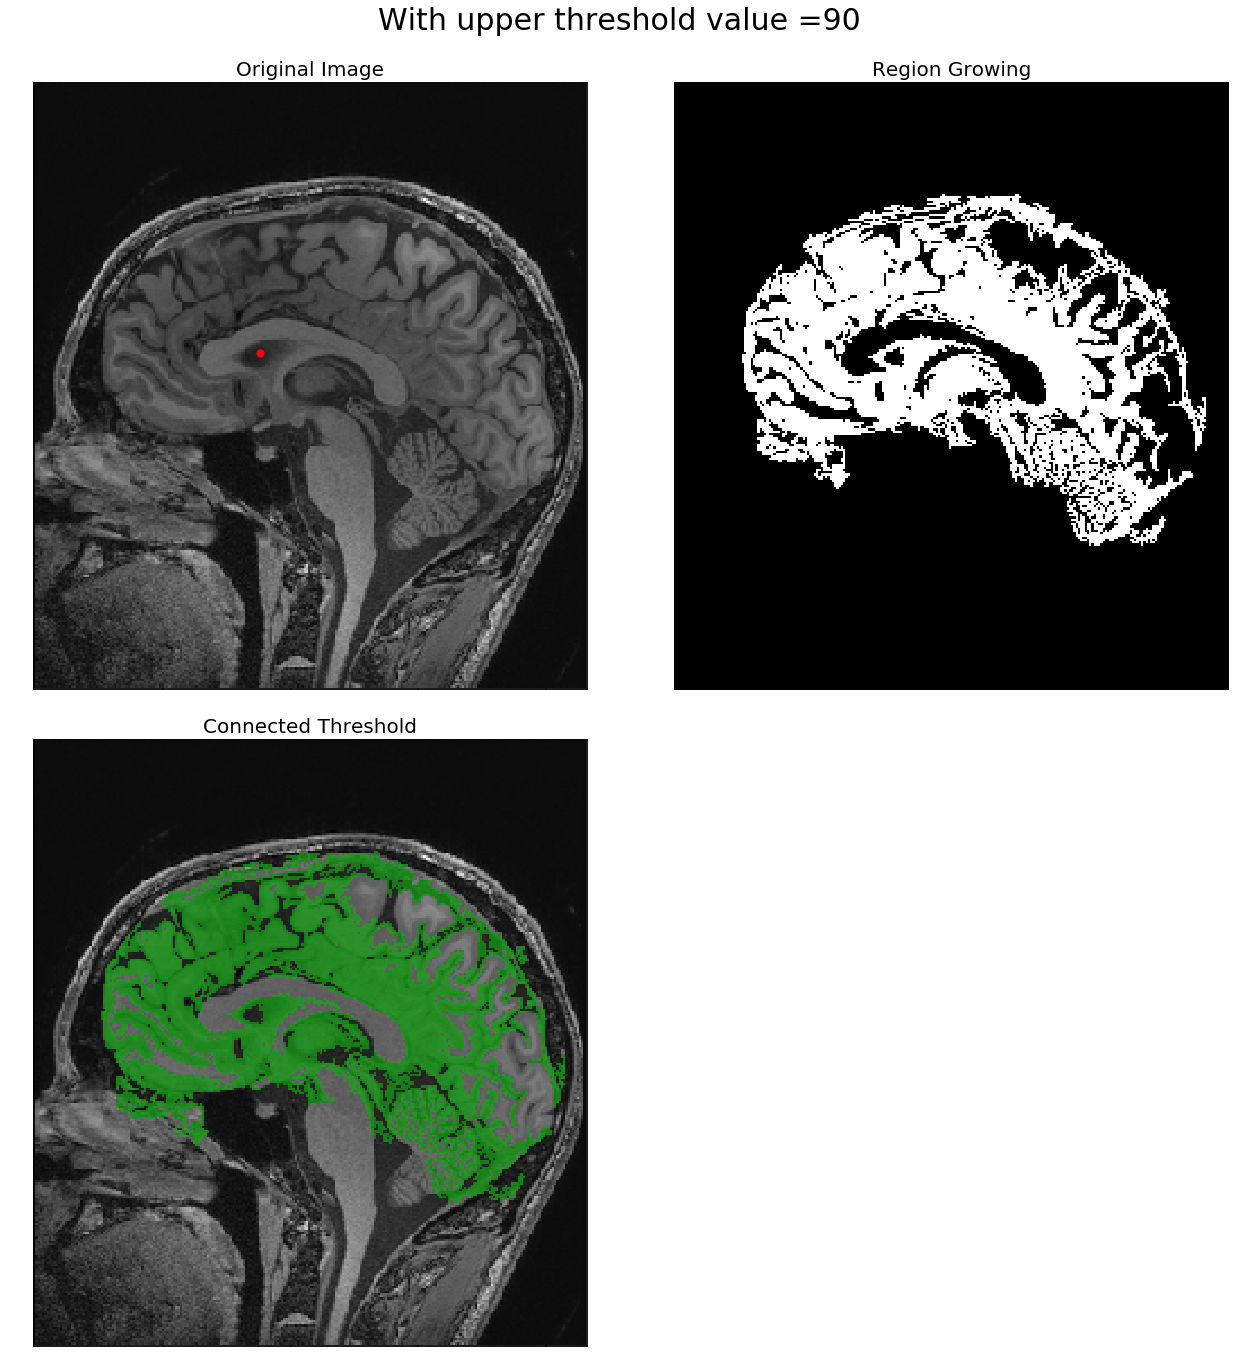

In [15]:
import SimpleITK as sitk # pip install SimpleITK 로 설치 필요

def show_image(img, title=None):
    nda = sitk.GetArrayViewFromImage(img)
    pylab.imshow(nda, cmap='gray'), pylab.axis('off')
    if (title): pylab.title(title, size=20)
        
img = 255*rgb2gray(imread('../images/mri_T1.png'))
img_T1 = sitk.GetImageFromArray(img)
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

seed = (100, 120)
for upper in [80, 85, 90]:
    seg1 = sitk.ConnectedThreshold(img_T1, seedList=[seed], lower=40, \
                               upper=upper)
    seg2 = sitk.LabelOverlay(img_T1_255, seg1)
    pylab.figure(figsize=(18,20))
    pylab.subplot(221), show_image(img_T1, "Original Image")
    pylab.scatter(seed[0], seed[1], color='red', s=50)
    pylab.subplot(222), show_image(seg1, "Region Growing")
    pylab.subplot(223), show_image(seg2, "Connected Threshold")
    pylab.suptitle('With upper threshold value ='+ str(upper), size = 30)
    pylab.axis('off'), pylab.tight_layout(rect=[0, 0.03, 1, 0.95])
    pylab.show()